In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot') 

from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import to_categorical
from keras.backend import clear_session

%matplotlib inline

## Loading the data and EDA

First I need to load the data and set the date as an index for my dataframe. Next I create all additional features: difference, percentage difference, data from previous days and means and put all of them into one dataframe.

In [245]:
# create the data parser
dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y')

# load the data
df = pd.read_csv('stock prices\GOOG.csv', parse_dates=['Date'], index_col=['Date'], date_parser=dateparse)
# drop adj close column
df.drop('Adj Close', axis=1, inplace=True)
    
# create a feature with value of all traded stocks during each day
df['Value'] = (df['Volume'] * (df['High'] + df['Low']) / 2).round(2)
    
# create a data with difference and percentage difference and add it to dataframe
difference = df.diff()
difference.columns = [col + ' diff' for col in df.columns]

percentage = df.pct_change()
percentage.columns = [col + ' % diff' for col in df.columns]
    
df = pd.concat([df, difference, percentage], axis=1)
    
# create data for 5, 10 and 21-days rolling means and 1, 2 and 3 previous dates and add it to dataframe
week_mean = df.rolling(5).mean().shift(1)
week_mean.columns = [col + ' 5-day mean' for col in df.columns]
    
fortnight_mean = df.rolling(10).mean().shift(1)
fortnight_mean.columns = [col + ' 10-day mean' for col in df.columns]
  
monthly_mean = df.rolling(21).mean().shift(1)
monthly_mean.columns = [col + ' 21-day mean' for col in df.columns]
  
one_day_ago = df.shift(1)
one_day_ago.columns = [col + ' - 1' for col in df.columns]

two_days_ago = df.shift(2)
two_days_ago.columns = [col + ' - 2' for col in df.columns]
    
three_days_ago = df.shift(3)
three_days_ago.columns = [col + ' - 3' for col in df.columns]
    
df = pd.concat([week_mean, fortnight_mean, monthly_mean,\
                         one_day_ago, two_days_ago, three_days_ago,\
                         df[['Open', 'Open diff', 'Open % diff',\
                             'Close', 'Close diff', 'Close % diff']]], axis=1)

## Creating and running a model

Before I start building my model I create my predicted variable which is the difference between opening price two days from now and tomorrow. Next I create X and y, split them into train and test and run throught my LSTM model.

In [246]:
# create helping variables
size = 21
multi = 12

# create target
df['Actual pct change'] = pd.DataFrame(df['Open'].shift(-1) / df['Open']) - 1
    
# drop null values
df.dropna(inplace=True)

# drop not needed values
df = df[-(size*multi):]

# create X and y
X = df.drop(['Close', 'Close diff', 'Close % diff', 'Actual pct change', 'Open', 'Open diff', 'Open % diff'], axis=1)
y = df[['Actual pct change']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1/multi), shuffle=False)

In [247]:
# scale the X and y dataframes
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

y_train_sc = ss.fit_transform(y_train)
y_test_sc = ss.transform(y_test)

# reshape the data into 3D so that it can be put into LSTM
X_train_sc2 = np.reshape(X_train_sc, (X_train_sc.shape[0], 1, X_train_sc.shape[1]))
X_test_sc2 = np.reshape(X_test_sc, (X_test_sc.shape[0], 1, X_test_sc.shape[1]))

In [248]:
# create a model
model = Sequential()
model.add(LSTM(100, batch_input_shape=(size, 1, X_train_sc2.shape[2]), return_sequences=True, stateful=True))
model.add(Dropout(.2))
model.add(LSTM(10))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

# fit the model
history = model.fit(X_train_sc2, y_train_sc, validation_data=(X_test_sc2, y_test_sc), epochs=5, batch_size=size, shuffle=False, verbose=1)

Train on 231 samples, validate on 21 samples
Epoch 1/5
231/231 [==============================] - 6s 27ms/step - loss: 1.0116 - val_loss: 2.9301
Epoch 2/5
231/231 [==============================] - 0s 403us/step - loss: 0.9476 - val_loss: 2.8741
Epoch 3/5
231/231 [==============================] - 0s 438us/step - loss: 0.9114 - val_loss: 2.8379
Epoch 4/5
231/231 [==============================] - 0s 238us/step - loss: 0.8871 - val_loss: 2.8299
Epoch 5/5
231/231 [==============================] - 0s 299us/step - loss: 0.8225 - val_loss: 2.8392


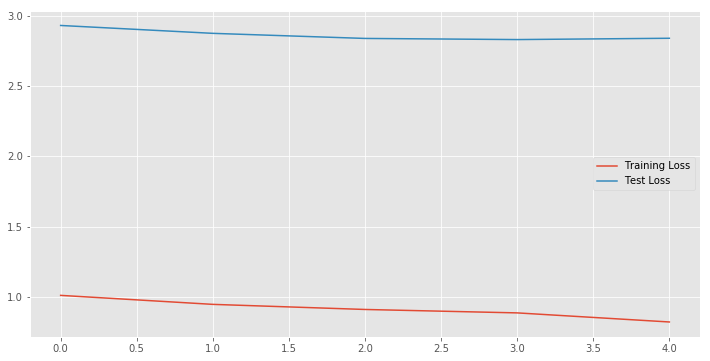

In [249]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()

In [250]:
# build a prediction dataframe
predict = pd.DataFrame(ss.inverse_transform(model.predict(X_test_sc2, batch_size=size)), columns=['Predicted pct change'], index=y_test.index)
predict = pd.concat([df[['Open', 'Close']][-y_test.shape[0]:], y_test, predict], axis=1)

predict['Predictions'] = df['Open'] * (predict['Predicted pct change'] + 1)
predict.head(3)

,Open,Close,Actual pct change,Predicted pct change,Predictions
Date,,,,,
2018-03-05,1075.140015,1090.930054,0.022397,-0.007385,1067.199833
2018-03-06,1099.219971,1095.060059,-0.009125,-0.008578,1089.790532
2018-03-07,1089.189941,1109.640015,0.023990,0.000727,1089.981455


In [251]:
# make decisions based on your predictions
predict['Decision'] = np.where(predict['Predicted pct change'] > 0, 1, 0)

# evaluate your decisions
predict['Gain/Loss pct'] = np.where(predict['Decision'] == 1, predict['Actual pct change'] + 1, 1 / (predict['Actual pct change'] + 1))

predict['Up'] = np.where(predict['Actual pct change'] > 0, 1, 0)
predict['Predicted Up'] = np.where(predict['Decision'] == 1, 1, 0)

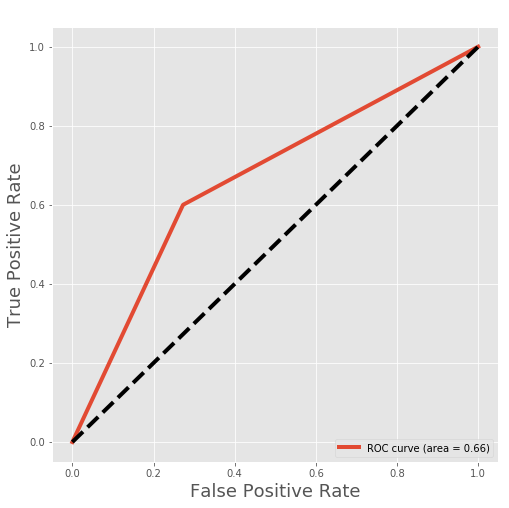

In [252]:
# create a roc curve
fpr, tpr, _ = roc_curve(predict['Up'], predict['Predicted Up'])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (is abnormal).
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Roc curve for price change', fontsize=18, color='w')
plt.legend(loc="lower right")
plt.savefig('roc.png', bbox_inches='tight')

## Finding best threshold

To use regression model into classification problem I need to figure out what threshold to use while classifing my predictions.

In [253]:
# create dictionaries to save my results with different threshold
results = {}
performances = {}

# Loop throught possible threshold from -2% to 2% and check the outcome when using this threshold
for i in np.arange(-0.02, 0.021, 0.0001):
    
    # make decisions based on your predictions
    predict['Decision'] = np.where(predict['Predicted pct change'] > i, 1, 0)

    # evaluate your decisions
    predict['Gain/Loss pct'] = np.where(predict['Decision'] == 1, predict['Actual pct change'] + 1, 1 / (predict['Actual pct change'] + 1))

    predict['Up'] = np.where(predict['Actual pct change'] > 0, 1, 0)
    predict['Predicted Up'] = np.where(predict['Decision'] == 1, 1, 0)

    predict['True positive'] = np.where((predict['Up'] == 1) & (predict['Predicted Up'] == 1), 1, 0)
    predict['False positive'] = np.where((predict['Up'] == 0) & (predict['Predicted Up'] == 1), 1, 0)
    predict['False negative'] = np.where((predict['Up'] == 1) & (predict['Predicted Up'] == 0), 1, 0)
    predict['True negative'] = np.where((predict['Up'] == 0) & (predict['Predicted Up'] == 0), 1, 0)

    # calculate your final result
    result = predict['Gain/Loss pct'].product() - 1

    # calculate market value change
    market = predict['Close'][-1] / predict['Close'][0] - 1

    # compare the values
    if market > 0:
        performance = result / market - 1
    else:
        performance = result / abs(market) + 1

    results[i] = result
    performances[i] = performance

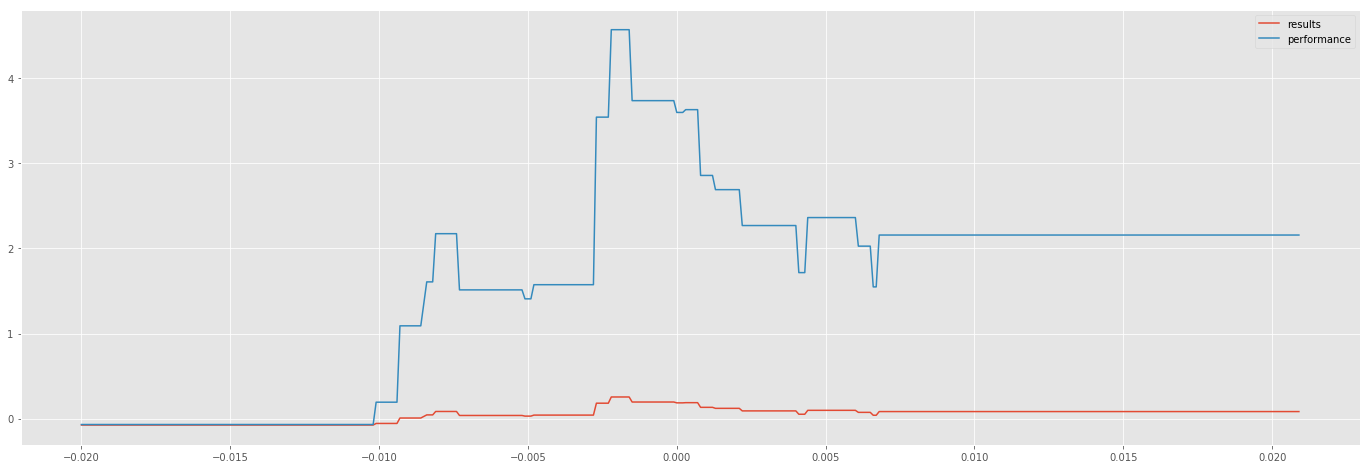

In [254]:
# Plot the possible outcomes on the graph
plt.figure(figsize=(24, 8))
plt.plot(results.keys(), results.values(), label='results')
plt.plot(performances.keys(), performances.values(), label='performance')
plt.legend()
plt.savefig('performance_best.png', bbox_inches='tight')

Check your optimal predictions

In [255]:
# make decisions based on your predictions
predict['Decision'] = np.where(predict['Predicted pct change'] > pd.Series(results).idxmax(), 1, 0)

# evaluate your decisions
predict['Gain/Loss pct'] = np.where(predict['Decision'] == 1, predict['Actual pct change'] + 1, 1 / (predict['Actual pct change'] + 1))

predict['Up'] = np.where(predict['Actual pct change'] > 0, 1, 0)
predict['Predicted Up'] = np.where(predict['Decision'] == 1, 1, 0)

In [256]:
# create confusion matrix
conmat = np.array(confusion_matrix(predict['Up'], predict['Predicted Up'], labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['up', 'down'],
                         columns=['predicted_up','predicted_down'])
confusion

,predicted_up,predicted_down
up,8,2
down,3,8


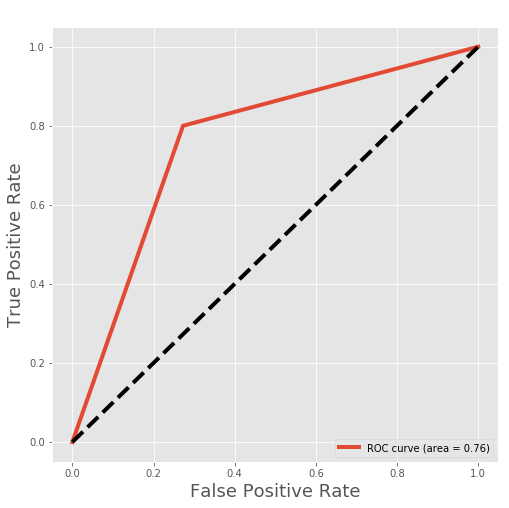

In [257]:
# create a roc curve
fpr, tpr, _ = roc_curve(predict['Up'], predict['Predicted Up'])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (is abnormal).
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Roc curve for price change after tunning', fontsize=18, color='w')
plt.legend(loc="lower right")
plt.savefig('roc_best.png', bbox_inches='tight')